In [158]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub/prj_on_boarding/")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub/prj_on_boarding


# 1. data load

In [159]:
df = pd.read_csv("/Users/yj.noh/Desktop/rfm_data.csv", encoding = "cp949")
print(df.isna().sum())
print(df.shape) #24,201 

brms_rider_id          0
work_start_week        0
recency               28
working_cycle         28
avg_daily_delivery    28
avg_day_income        28
avg_week_income       28
dtype: int64
(24201, 7)


In [160]:
df = df[df['avg_daily_delivery'].notnull()]
print(df.shape) # 24173

(24173, 7)


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24173 entries, 0 to 24200
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brms_rider_id       24173 non-null  object 
 1   work_start_week     24173 non-null  object 
 2   recency             24173 non-null  float64
 3   working_cycle       24173 non-null  float64
 4   avg_daily_delivery  24173 non-null  float64
 5   avg_day_income      24173 non-null  float64
 6   avg_week_income     24173 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.5+ MB


In [162]:
df.describe()

,recency,working_cycle,avg_daily_delivery,avg_day_income,avg_week_income
count,24173.000000,24173.000000,24173.000000,24173.000000,2.417300e+04
mean,17.185289,2.359667,7.556199,35073.727682,1.145104e+05
std,22.275579,2.574821,7.069497,34941.166192,1.593741e+05
min,0.000000,1.000000,1.000000,0.000000,0.000000e+00
25%,0.000000,1.000000,2.500000,10340.000000,1.583333e+04
50%,6.000000,1.500000,5.166667,22590.000000,4.959333e+04
75%,28.000000,2.500000,10.240000,47855.185185,1.431067e+05
max,84.000000,39.500000,68.744681,317941.702128,1.660362e+06


In [163]:
df['work_start_week'] = df['work_start_week'].astype('category')

ordered_cats = ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D',
               '10W1D', '10W2D', '10W3D', '10W4D', '10W5D']

df['work_start_week'] = df['work_start_week'].cat.reorder_categories(ordered_cats)


# 2. graph 

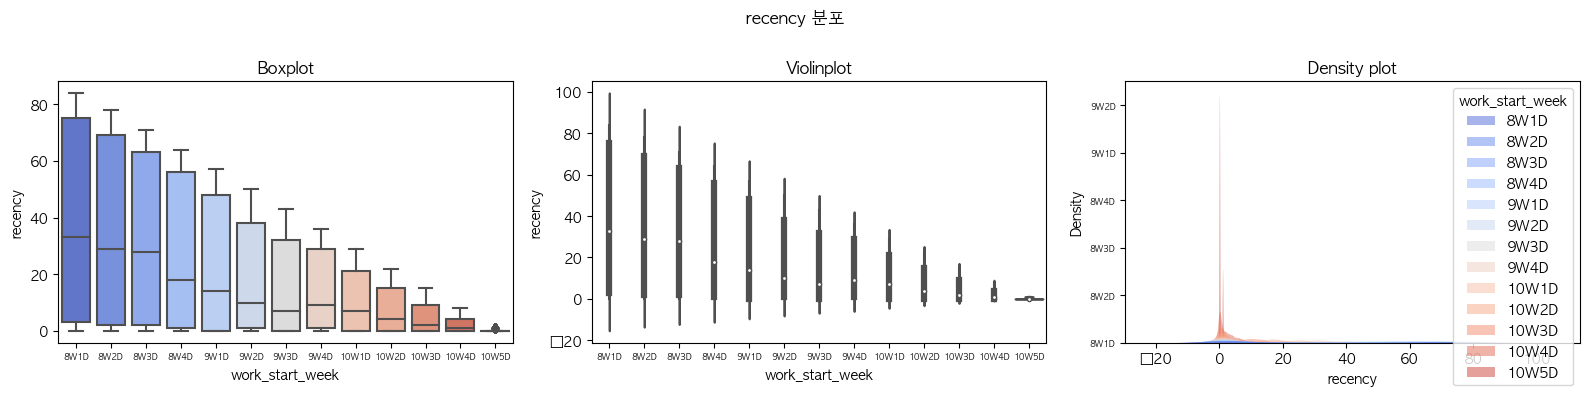

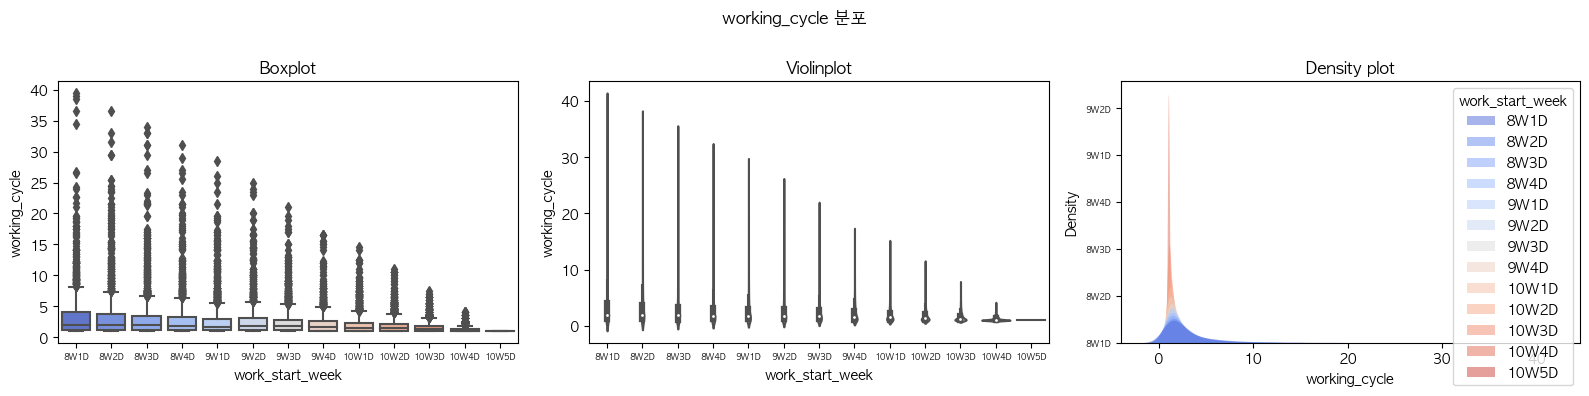

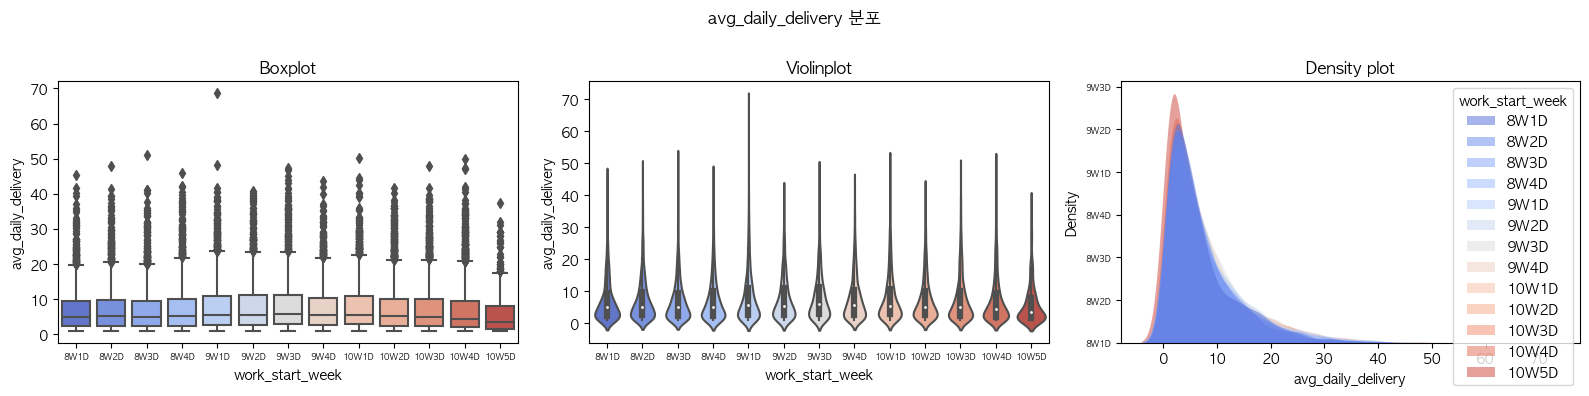

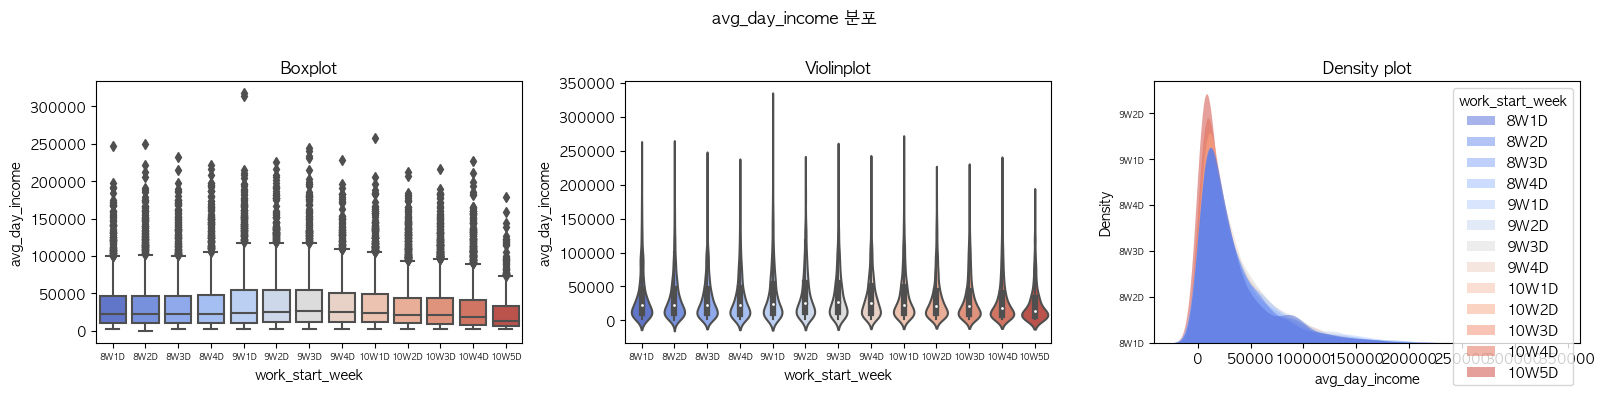

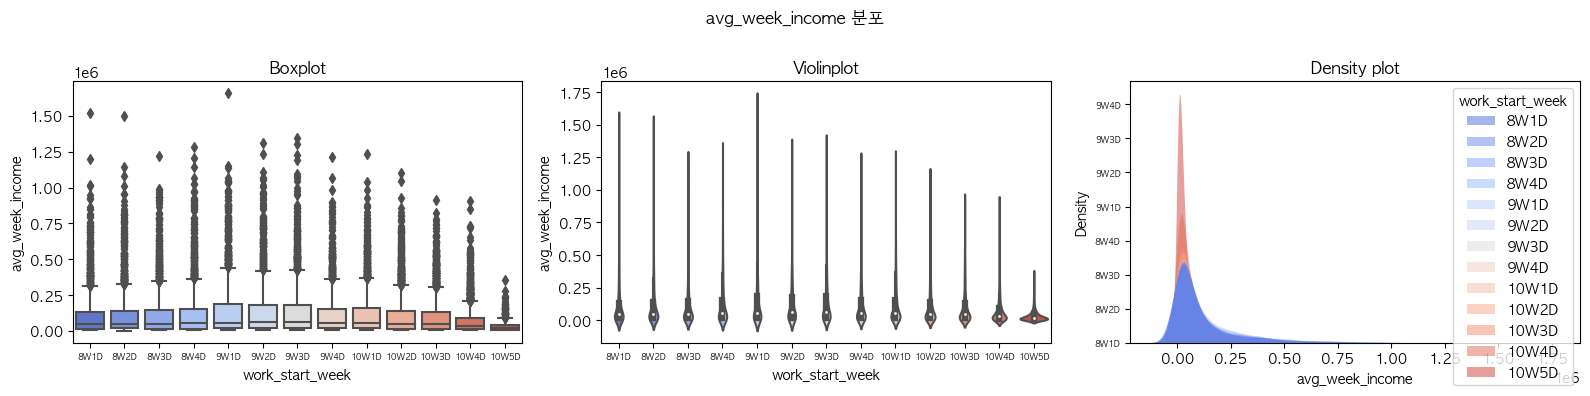

In [164]:
def plot_numeric (data, numeric_vars, outcome):
        
    palette = 'coolwarm'
    
    os.makedirs('rfm_graphs', exist_ok = True)
    
    for num_var in numeric_vars:
        fig, axs = plt.subplots(1,3, figsize=(16,4))
        fig.suptitle(f'{num_var} 분포', fontsize = 12)
    
        # Boxplot
        sns.boxplot(ax=axs[0],  x= outcome, y=num_var, data= data, palette = palette)
        axs[0].set_xticklabels(labels =  ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D','10W1D',  '10W2D', '10W3D', '10W4D','10W5D'],
                               fontsize =6)
        axs[0].set_title('Boxplot')
            
        # Violinplot
        sns.violinplot(ax=axs[1],  x= outcome, y = num_var, data = data, palette = palette)
        axs[1].set_xticklabels(labels =  ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D','10W1D',  '10W2D', '10W3D', '10W4D','10W5D'],
                               fontsize =6)
        axs[1].set_title('Violinplot')
        
        # KDE plot
        sns.kdeplot(ax=axs[2], data = data, x = num_var, fill = True, hue = outcome, common_norm = False, palette = palette, alpha=.5, linewidth=0, legend = True)
        axs[2].set_yticklabels(labels =  ['8W1D', '8W2D', '8W3D', '8W4D', '9W1D', '9W2D', '9W3D', '9W4D','10W1D',  '10W2D', '10W3D', '10W4D','10W5D'],
                               fontsize =6)
        axs[2].set_title('Density plot')
        #axs[2].legend(fontsize='medium')
     
        plt.tight_layout()
        fig.subplots_adjust(top=0.8) # title 공간 확보
        
        fig.savefig(f'rfm_graphs/{num_var}_distributions.png')
        plt.show()
        plt.close(fig)

numeric_vars = ['recency', 'working_cycle', 'avg_daily_delivery', 'avg_day_income', 'avg_week_income']
plot_numeric(df, numeric_vars, 'work_start_week')

# 3. 데이터 전처리

## 3-1. boxplot

In [165]:
def calculate_statistics(data, variable_name):
    Q1 = data[variable_name].quantile(0.25)
    median = data[variable_name].quantile(0.50)
    Q3 = data[variable_name].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    max_val = data[variable_name].max()

    return Q1, median, Q3, upper_bound, max_val

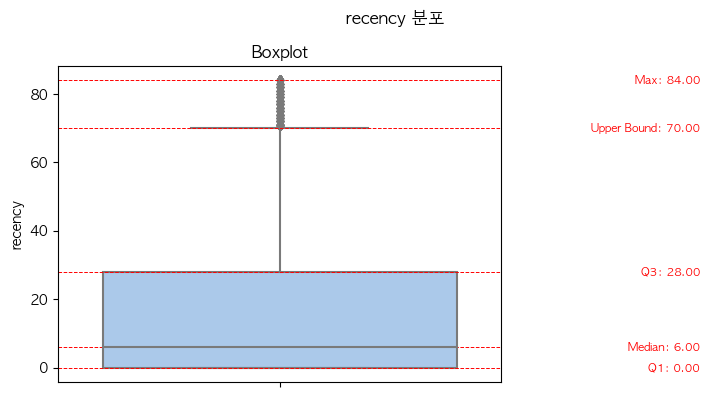

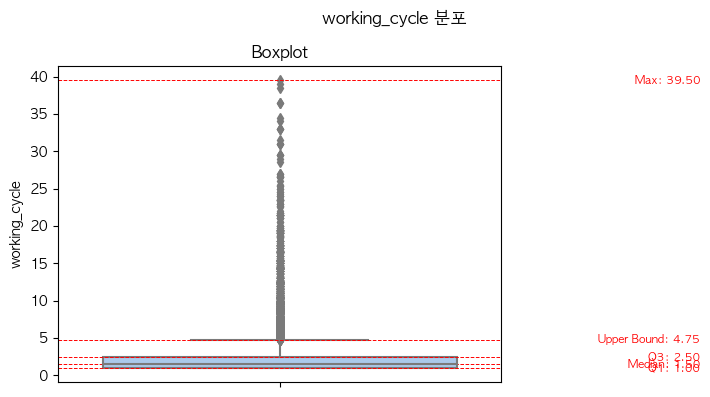

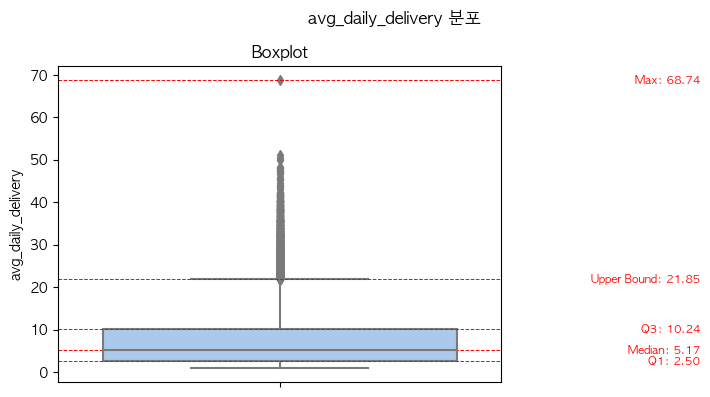

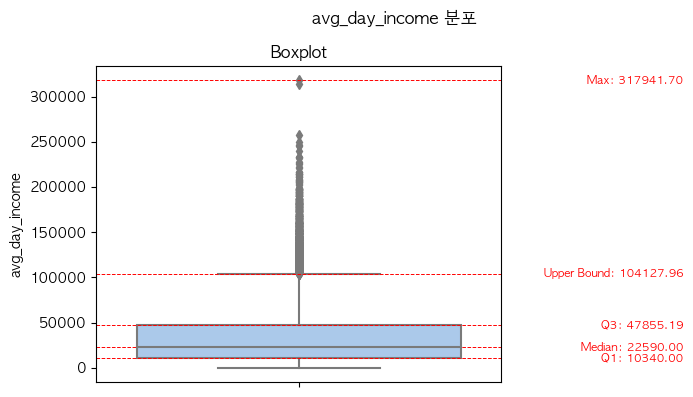

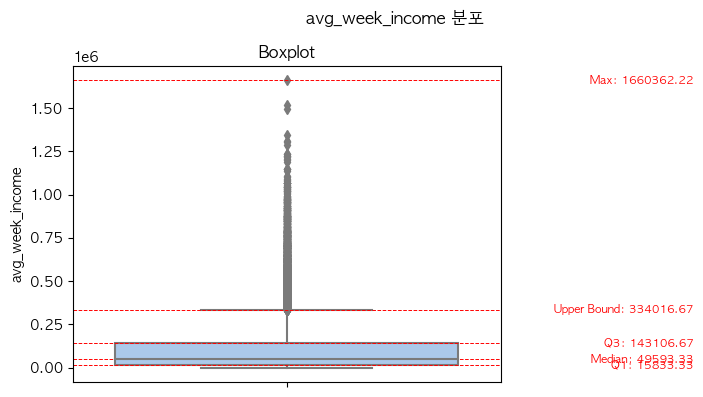

In [166]:
def box_plot_numeric(data, numeric_vars):        
    palette = 'pastel'
    os.makedirs('rfm_graphs', exist_ok=True)
    
    for num_var in numeric_vars:
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(f'{num_var} 분포', fontsize=12)
    
        # Boxplot
        sns.boxplot(y=num_var, data=data, palette=palette, ax=ax)
        ax.set_title('Boxplot')

        # Statistics for the numeric variable
        Q1, median, Q3, upper_bound, max_val = calculate_statistics(data, num_var)
        
        for value, label in zip([Q1, median, Q3, upper_bound, max_val], 
                                ['Q1', 'Median', 'Q3', 'Upper Bound', 'Max']):
            ax.axhline(y=value, color='r', linestyle='--', lw=0.7)
            ax.text(0.95, value, f"{label}: {value:.2f}", va='center', ha='right', color='r', fontsize=8)
        
        plt.tight_layout()
        fig.subplots_adjust(top=0.84)
        
        fig.savefig(f'rfm_graphs/{num_var}_boxplot.png')
        plt.show()
        plt.close(fig)

numeric_vars = ['recency', 'working_cycle', 'avg_daily_delivery', 'avg_day_income', 'avg_week_income']
box_plot_numeric(df, numeric_vars)


## 3-2. 데이터 탐색

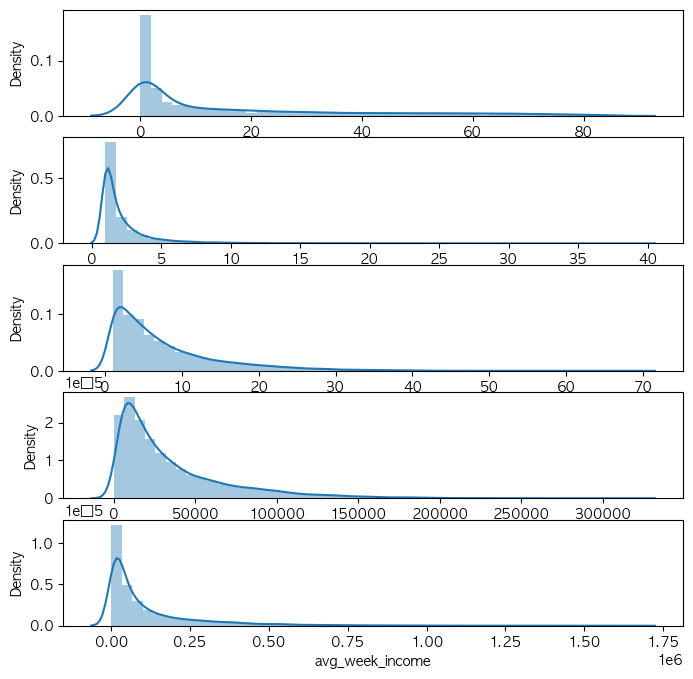

In [167]:
plt.figure(figsize=(8,8))

plt.subplot(5, 1, 1); sns.distplot(df['recency'])
plt.subplot(5, 1, 2); sns.distplot(df['working_cycle'])
plt.subplot(5, 1, 3); sns.distplot(df['avg_daily_delivery'])
plt.subplot(5, 1, 4); sns.distplot(df['avg_day_income'])
plt.subplot(5, 1, 5); sns.distplot(df['avg_week_income'])

plt.show()

### 데이터 조정

In [168]:
# scale
#scaler = StandardScaler()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[numeric_vars])
df_scaled = pd.DataFrame(df_scaled, columns = numeric_vars, index = df.index)

categorical_cols = [col for col in df.columns if col not in numeric_vars]
df_cate = df[categorical_cols]

scaled_df = pd.concat([df_scaled, df_cate], axis = 1)
print(scaled_df.head())

    recency  working_cycle  avg_daily_delivery  avg_day_income  \
0  0.071429       0.476190            0.019682        0.026745   
1  0.000000       0.025210            0.369467        0.403615   
2  0.000000       0.013605            0.008084        0.017535   
3  0.142857       0.000000            0.007381        0.017472   
4  0.261905       0.000000            0.000000        0.011449   

   avg_week_income                                      brms_rider_id  \
0         0.007682  5E206452A48BEDAF6CD61DCD01C4D3331686F89B5C94CE...   
1         0.262779  A948953991453C16E3D57BFF3D301BBCE1E9856AB16265...   
2         0.014102  61DCD377479A8550EEA42404CAED40E1F95E2CA0CB25CA...   
3         0.006691  289C3DD67E62462ED43F9BFBF6C0324C0C3AFC39F14A71...   
4         0.002192  1ABBD7CD676CB2DC218BD85CCB009B357C4F6456CA5F54...   

  work_start_week  
0            8W4D  
1            8W3D  
2            8W4D  
3           10W3D  
4           10W2D  


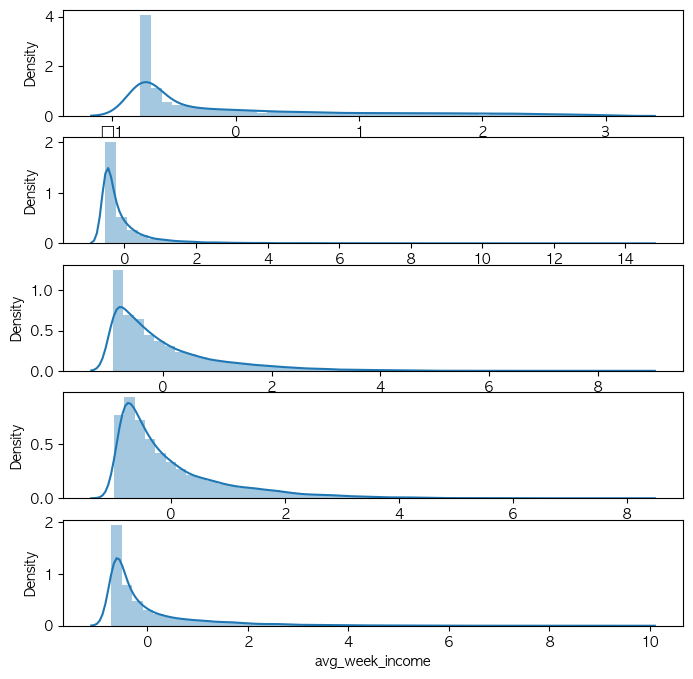

In [147]:
plt.figure(figsize=(8,8))

plt.subplot(5, 1, 1); sns.distplot(scaled_df['recency'])
plt.subplot(5, 1, 2); sns.distplot(scaled_df['working_cycle'])
plt.subplot(5, 1, 3); sns.distplot(scaled_df['avg_daily_delivery'])
plt.subplot(5, 1, 4); sns.distplot(scaled_df['avg_day_income'])
plt.subplot(5, 1, 5); sns.distplot(scaled_df['avg_week_income'])

plt.show()

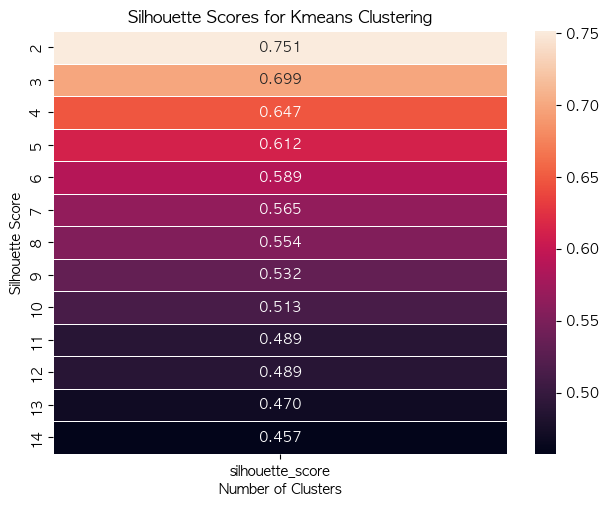

In [154]:
def visualize_silhouette_scores(data, method, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2, 15)
    results = []

    for i in clusters_range:
        if method == 'kmeans':
            clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        elif method == 'agglomerative':
            clusterer = AgglomerativeClustering(n_clusters=i)
        else:
            raise ValueError("Invalid method. Choose 'kmeans' or 'agglomerative'.")

        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    
    plt.figure()
    sns.heatmap(pd.pivot_table(result, index="n_clusters", values="silhouette_score"),annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.title(f"Silhouette Scores for {method.capitalize()} Clustering")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()
    
visualize_silhouette_scores(df[numeric_vars], 'kmeans' )

In [156]:
random.seed(1234)
n_clusters = 2
km = KMeans(n_clusters = n_clusters, random_state = 22)
km.fit(df[numeric_vars])

centers = km.cluster_centers_
print(centers)


[[1.94924961e+01 2.52571541e+00 5.36984756e+00 2.40962340e+04
  5.98167196e+04]
 [3.63463179e+00 1.38443224e+00 2.03970535e+01 9.95466053e+04
  4.35736580e+05]]


In [ ]:
# def analyze_skewness(data,x):
#     fig, ax = plt.subplots(2, 2, figsize=(5,5))
#     sns.distplot(data[x], ax=ax[0,0])
#     sns.distplot(np.log(data[x]), ax=ax[0,1])
#     sns.distplot(np.sqrt(data[x]), ax=ax[1,0])
#     sns.distplot(stats.boxcox(data[x]), ax=ax[1,1])
#     plt.tight_layout()
#     plt.show()

# analyze_skewness(df, 'working_cycle')

In [ ]:
# def score_percent(data, variable_name):
#     t1 = data[variable_name].quantile(0.20)
#     t2 = data[variable_name].quantile(0.40)
#     t3 = data[variable_name].quantile(0.60)
#     t4 = data[variable_name].quantile(0.80)
    
#     def categorize(val):
#         if val <= t1:
#             return 1
#         elif t1 < val <= t2:
#             return 2
#         elif t2 < val <= t3:
#             return 3
#         elif t3 < val <= t4:
#             return 4
#         else:
#             return 5  
    
#     data[f'{variable_name}_score'] = data[variable_name].apply(categorize)
#     return data
 
# score_percent(df, 'recency') 
# print(df['recency_score'].value_counts())

In [ ]:
# def calculate_statistics(data, variable_name):
#     Q1 = data[variable_name].quantile(0.25)
#     median = data[variable_name].quantile(0.50)
#     Q3 = data[variable_name].quantile(0.75)
#     IQR = Q3 - Q1
#     upper_bound = Q3 + 1.5 * IQR
#     max_val = data[variable_name].max()
#     mid_point = (upper_bound + max_val) /2
    
#     def categorize(val):
#         if val <= median:
#             return 1
#         elif median < val <= Q3:
#             return 2
#         elif Q3 < val <= upper_bound:
#             return 3
#         elif upper_bound < val <= mid_point:
#             return 4
#         else:
#             return 5  # 극단점의 경계를 초과하는 값들은 5로
#     data[f'{variable_name}_score2'] = data[variable_name].apply(categorize)
#     return data

# calculate_statistics(df, 'recency')
# print(df['recency_score2'].value_counts())